# Online Dating Sentiment Analysis

### PROBLEM STATEMENT:

- Based on user comments and sentiment, are there ways for dating apps to improve their services?

- Is it possible to categorize human emotions in online dating apps by analyzing comments posted by users?

### Data Collection & Preparation

Data was gathered from a famous social network website in America, Reddit.com. Using the Reddit API to access the data, three well known online dating companies was selected, Bumble, Hinge and Tinder to analyze.

To improve the availability of getting the online dating forums data I used 'praw' (Python Reddit API Wrapper) library to scrape the forums and extract the data in a more readable manner. Over 2.6k valid comments was collected.

In [1]:
pip install praw

Note: you may need to restart the kernel to use updated packages.


In [58]:
import praw 
from praw.models import MoreComments
import pandas as pd
import numpy as np
from collections import Counter
import re
import seaborn as sns
import datetime
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter, defaultdict

In [41]:
user_agent= "scrapper 1.0 by /u/Key_Oil_3506"
reddit = praw.Reddit(
    client_id="e1knmcTqxXGaQldGnCXZew",
    client_secret="ewR7Bo_tAGER1aB6DsmjZrf9Ok3vmA",
    user_agent=user_agent
)

In [42]:
def scrape_subreddit_comments(subreddit_name, limit=None):
    subreddit = reddit.subreddit(subreddit_name)
    df = []
    for post in subreddit.hot(limit=limit):
        df.append([
            subreddit_name, 
            post.id, 
            post.title, 
            post.author.name if post.author else None, 
            post.score, 
            post.created_utc, 
            post.url, 
            post.num_comments, 
            post.selftext
        ])
    return pd.DataFrame(df, columns=['subreddit', 'id', 'title', 'author', 'score', 'created_utc', 'url', 'num_comments', 'body'])


In [43]:
# List of subreddits to scrape
subreddits = ['Tinder', 'Bumble', 'hingeapp']
df_list = []

for subreddit in subreddits:
    df_list.append(scrape_subreddit_comments(subreddit))

In [44]:
# Combine data into a single DataFrame
combined_df = pd.concat(df_list, ignore_index=True)

In [45]:
# Display the combined DataFrame
print(combined_df)

     subreddit       id                                              title  \
0       Tinder  1egsbvz                       Weekly Profile Review Thread   
1       Tinder  1egsfw7                           Weekly story time thread   
2       Tinder  1ehq2gi                                      Am I cooking?   
3       Tinder  1ehbezu                          My dad joke fell flat lol   
4       Tinder  1ehedid  Why is a coffee date a red flag but drinks on ...   
...        ...      ...                                                ...   
2621  hingeapp  1cxu3tr      Wednesday's Daily Thread: Mid-week Excitement   
2622  hingeapp  1cx8fqy  How do you deal with rejection when the dates ...   
2623  hingeapp  1cx43ic                    Advice for failed relationship    
2624  hingeapp  1cxkliu                Updated Dating Profile Review (25M)   
2625  hingeapp  1cxgvl7  31 M Profile Review. Getting back out there af...   

                    author  score   created_utc  \
0           

In [46]:
# Save the combined DataFrame to a CSV file
combined_df.to_csv('reddit_posts.csv', index=False)

print("Data has been saved to reddit_posts.csv")

Data has been saved to reddit_posts.csv


In [75]:
# Get number of rows and columns
num_rows, num_columns = combined_df.shape

# Convert 'created_utc' to datetime
combined_df['created_utc'] = pd.to_datetime(combined_df['created_utc'], unit='s')

# Get date period
date_period_start = combined_df['created_utc'].min()
date_period_end = combined_df['created_utc'].max()

# Print data information
print(f"Total number of comments collected: {total_comments}")
print(f"Number of Columns: {num_columns}")
print(f"Date Period: From {date_period_start} to {date_period_end}")

Total number of comments collected: 2626
Number of Columns: 9
Date Period: From 2024-05-21 09:54:35 to 2024-08-02 03:48:36


### Text Analysis

Word Frequency was done to get an idea of which type of data we have in the dataset, frequency of words was analyzed and a rank was created.

In [48]:
# Analyze word frequency in 'body' column
all_words = ' '.join(combined_df['body'].dropna()).lower()
all_words = re.findall(r'\b\w+\b', all_words)
word_freq = Counter(all_words)
word_rank = sorted(word_freq.items(), key=lambda item: item[1], reverse=True)

In [49]:
# Convert word rank to DataFrame for better visualization
word_rank_df = pd.DataFrame(word_rank, columns=['word', 'frequency'])

print("Top 10 Words:\n", word_rank_df.head(10))

Top 10 Words:
    word  frequency
0     i       8451
1    to       5022
2   and       4643
3     a       4338
4   the       4109
5    it       2233
6    of       2030
7  that       1968
8    on       1924
9   for       1873


In [50]:
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

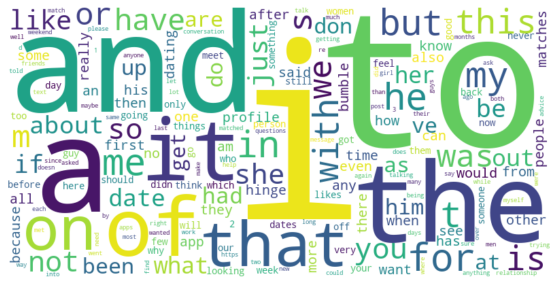

In [51]:
# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Phrase Analysis
Categorizing the words and phrases into three separate categories improved the analysis. 

Each dictionary entry was categorized into either “Match Experience”, “Experience Quality”, or “Relationship Type.

In [67]:
# Define categories and phrases
categories = {
    'Match Experience': ['date', 'match', 'love', 'relationship', 'ghosted', 'catfish'],
    'Experience Quality': ['good', 'bad', 'great', 'terrible', 'fun', 'fake'],
    'Relationship Type': ['friend', 'partner', 'casual', 'serious', 'in', 'love']
}

In [68]:
# Categorize words
categorized_data = defaultdict(Counter)
for word, freq in word_rank:
    for category, keywords in categories.items():
        if word in keywords:
            categorized_data[category][word] += freq

In [69]:
# Initialize counters for each subreddit and each category
counters = {subreddit: defaultdict(Counter) for subreddit in subreddits}

In [70]:
# Count occurrences of phrases in each subreddit
for index, row in combined_df.iterrows():
    subreddit = row['subreddit']
    text = row['body'].lower() if pd.notna(row['body']) else ""
    for category, phrases in categories.items():
        for phrase in phrases:
            if phrase in text:
                counters[subreddit][category][phrase] += 1


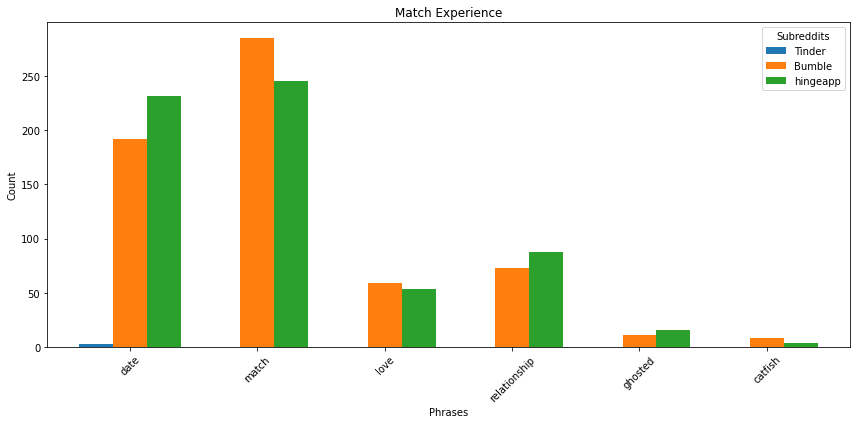

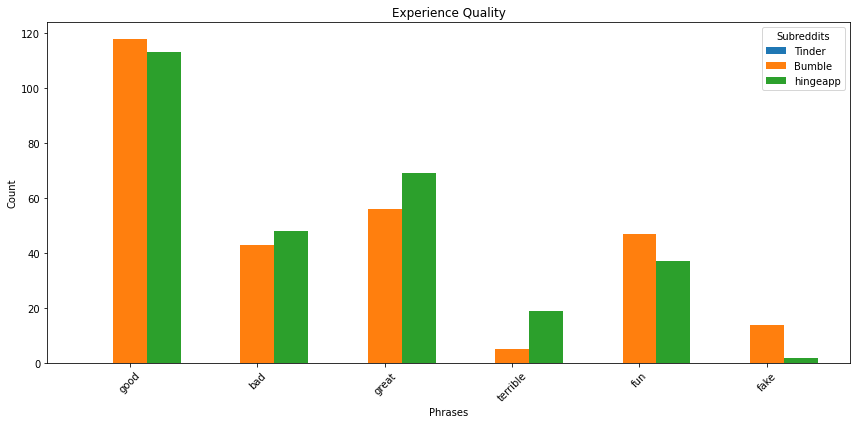

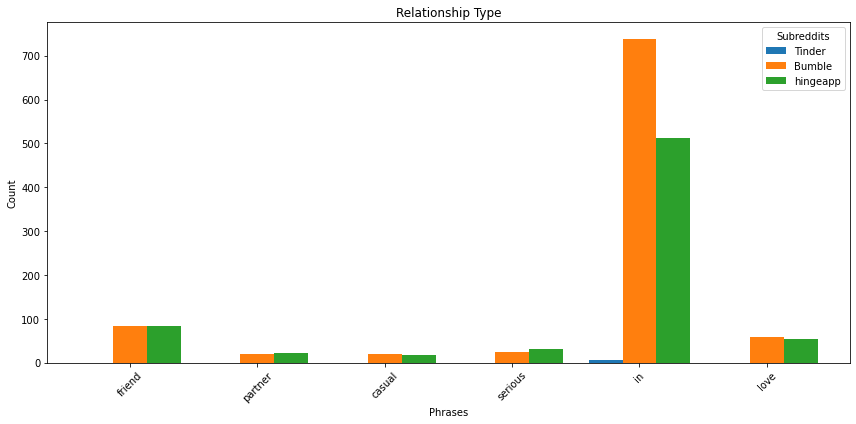

In [71]:
# Convert counters to DataFrame for plotting
plot_dfs = {}
for category in categories:
    data = {subreddit: [counters[subreddit][category][phrase] for phrase in categories[category]] for subreddit in subreddits}
    plot_dfs[category] = pd.DataFrame(data, index=categories[category])

# Plotting the data
for category, plot_df in plot_dfs.items():
    ax = plot_df.plot(kind='bar', figsize=(12, 6), width=0.8)
    ax.set_title(f'{category}')
    ax.set_xlabel('Phrases')
    ax.set_ylabel('Count')
    ax.legend(title='Subreddits')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### Conclusion and Future Direction:
- By using NLP techniques and sentiment analysis, it is possible to categorize human emotions in online dating app comments. 

- This approach can provide valuable insights into user experiences and help developers enhance the emotional engagement and satisfaction of their apps.

- Because many users were asking for dating advice, match quality could potentially be improved by offering more behavioral questions based on dating and communication style.